# Poisoning Hugging Face Models using ART

In this notebook, we will go over how to use ART to poison a Hugging Face image classifier. We will be applying the dirty label backdoor attack (DLBD) on the Imagenette dataset and fine-tuning a pre-trained Data-efficient Image Transformer (DeiT) model available from Hugging Face.

After showing the effect of poison, we will be demonstrating the DP-InstaHide poisoning defense. DP-InstaHide is a training method developed by [Borgnia et. al. (2021)](https://arxiv.org/abs/2103.02079). This method provides a differential privacy guarantee and strong empirical performance against poisoning attacks. The training protocol uses:
* Data augmentation (such as Mixup)
* Additive noise (such as Laplacian noise)

In addition to the core ART dependencies you will need to install Pytorch and the Transformers library:

`pip install torch torchvision`

`pip install transformers`

Let's look at how we can use ART to both attack and defend Hugging Face models!

### The Attack: Misclassification

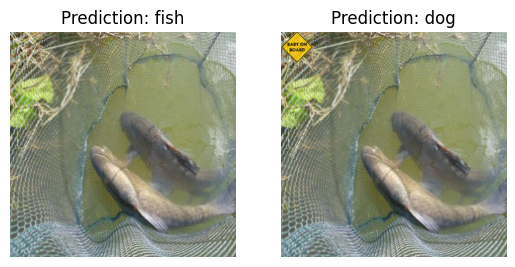

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import transformers

from art.estimators.classification.hugging_face import HuggingFaceClassifierPyTorch
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.attacks.poisoning.perturbations import insert_image
from art.defences.preprocessor import Mixup
from art.defences.trainer import DPInstaHideTrainer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Data

For this demo, we will be using the Imagenette dataset with 10 classes. Download the 320px Imagenette dataset from here: <https://github.com/fastai/imagenette>. Afterwards, create directory named `data` and extract the tar file into that newly created directory.

In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
])

train_dataset = torchvision.datasets.ImageFolder(root="./data/imagenette2-320/train", transform=transform)
train_dataset

Dataset ImageFolder
    Number of datapoints: 9469
    Root location: ./data/imagenette2-320/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [3]:
# We will use a small subset of the Imagenett dataset

labels = np.asarray(train_dataset.targets)
classes = np.unique(labels)
samples_per_class = 100

x_subset = []
y_subset = []

for c in classes:
    indices = np.where(labels == c)[0][:samples_per_class]
    for i in indices:
        x_subset.append(train_dataset[i][0])
        y_subset.append(train_dataset[i][1])

x_subset = np.stack(x_subset)
y_subset = np.asarray(y_subset)

print(f'x_subset:', x_subset.dtype, x_subset.shape)
print(f'y_subset:', y_subset.dtype, y_subset.shape)

x_subset: float32 (1000, 3, 224, 224)
y_subset: int64 (1000,)


In [4]:
label_names = [
    'fish',
    'dog',
    'cassette player',
    'chainsaw',
    'church',
    'french horn',
    'garbage truck',
    'gas pump',
    'golf ball',
    'parachutte',
]

In [5]:
# Create state_dicts directory for saving models

if not os.path.isdir('./state_dicts'):
    os.mkdir('./state_dicts')

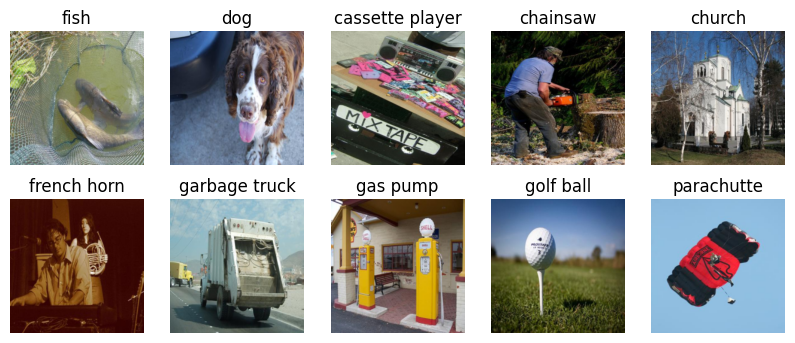

In [6]:
fig, ax = plt.subplots(2, 5, figsize=(10, 4))
for i in range(0, 5):
    ax[0, i].imshow(np.transpose(x_subset[i * 100], (1, 2, 0)))
    ax[0, i].set_title(label_names[y_subset[i * 100]])
    ax[0, i].axis('off')
    ax[1, i].imshow(np.transpose(x_subset[i * 100 + 500], (1, 2, 0)))
    ax[1, i].set_title(label_names[y_subset[i * 100 + 500]])
    ax[1, i].axis('off')

plt.show()

# Poison Dataset

We will be using the baby-on-board trigger to poison images of a fish into a dog.

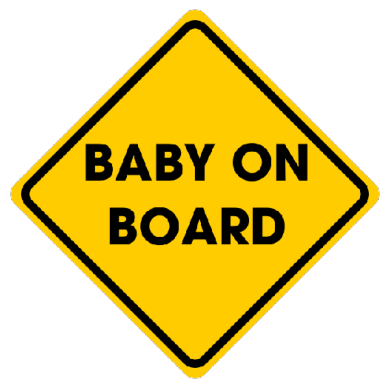

In [7]:
trigger = plt.imread('../utils/data/backdoors/baby-on-board.png')
plt.imshow(trigger)
plt.axis('off')
plt.show()

In [8]:
def poison_func(x):
    return insert_image(
        x,
        backdoor_path='../utils/data/backdoors/baby-on-board.png',
        channels_first=True,
        random=False,
        x_shift=0,
        y_shift=0,
        size=(32, 32),
        mode='RGB',
        blend=0.8
    )

backdoor = PoisoningAttackBackdoor(poison_func)

source_class = 0
target_class = 1
poison_percent = 0.5

x_poison = np.copy(x_subset)
y_poison = np.copy(y_subset)
is_poison = np.zeros(len(x_subset)).astype(bool)

indices = np.where(y_subset == source_class)[0]
num_poison = int(poison_percent * len(indices))

for i in indices[:num_poison]:
    x_poison[i], _ = backdoor.poison(x_poison[i], [])
    y_poison[i] = target_class
    is_poison[i] = True

poison_indices = np.where(is_poison)[0]

print(f'x_poisoned:', x_poison.dtype, x_poison.shape)
print(f'y_poisoned:', y_poison.dtype, y_poison.shape)
print('total poisoned train:', np.sum(is_poison))

x_poisoned: float32 (1000, 3, 224, 224)
y_poisoned: int64 (1000,)
total poisoned train: 50


## Poison Hugging Face Model

We will be using the Data-efficient Image Transformer (DeiT) model from Hugging Face pre-trained on the Imagenet dataset. We will be fine-tuning this model on the poisoned dataset.

In [9]:
model = transformers.AutoModelForImageClassification.from_pretrained(
    'facebook/deit-tiny-distilled-patch16-224',
    ignore_mismatched_sizes=True,
    num_labels=10
)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()

hf_model = HuggingFaceClassifierPyTorch(
    model=model,
    loss=loss_fn,
    optimizer=optimizer,
    input_shape=(3, 224, 224),
    nb_classes=10,
    clip_values=(0, 1),
)

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-tiny-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([10, 192]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([10, 192]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# load saved model if it already exists, otherwise train it

model_checkpoint_path = './state_dicts/deit_imagenette_poisoned_model.pt'
if os.path.isfile(model_checkpoint_path):
    hf_model.model.load_state_dict(torch.load(model_checkpoint_path, map_location=device))
    print('loaded model checkpoint')
else:
    hf_model.fit(x_poison, y_poison, nb_epochs=2)
    torch.save(hf_model.model.state_dict(), model_checkpoint_path)
    print('saved model checkpoint')

loaded model checkpoint


### Evaluate on Clean Data

In [11]:
clean_x = x_poison[~is_poison]
clean_y = y_poison[~is_poison]

outputs = hf_model.predict(clean_x)
clean_preds = np.argmax(outputs, axis=1)
clean_acc = np.mean(clean_preds == clean_y)
print('clean accuracy:', clean_acc)

clean accuracy: 0.9842105263157894


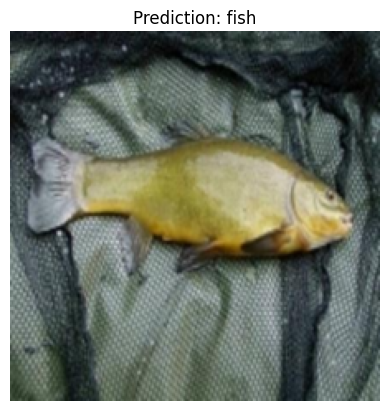

In [12]:
plt.imshow(np.transpose(clean_x[3], (1, 2, 0)))
plt.title(f'Prediction: {label_names[clean_preds[3]]}')
plt.axis('off')
plt.show()

### Evaluate on Poison Data

In [13]:
poison_x = x_poison[is_poison]
poison_y = y_poison[is_poison]

outputs = hf_model.predict(poison_x)
poison_preds = np.argmax(outputs, axis=1)
poison_acc = np.mean(poison_preds == poison_y)
print('poison success rate:', poison_acc)

poison success rate: 0.9


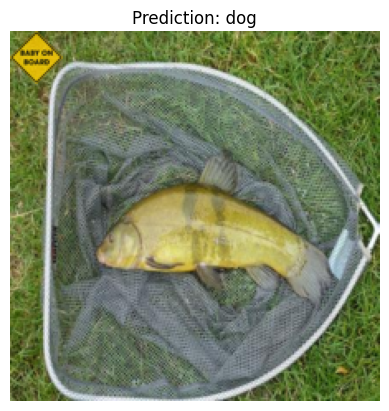

In [14]:
plt.imshow(np.transpose(poison_x[4], (1, 2, 0)))
plt.title(f'Prediction: {label_names[poison_preds[4]]}')
plt.axis('off')
plt.show()

## Defend against Poison using DP-InstaHide

We will be perform the fine-tuning again, but using the DP-InstaHide poisoning defense.

In [15]:
model = transformers.AutoModelForImageClassification.from_pretrained(
    'facebook/deit-tiny-distilled-patch16-224',
    ignore_mismatched_sizes=True,
    num_labels=10
)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()

hf_model = HuggingFaceClassifierPyTorch(
    model=model,
    loss=loss_fn,
    optimizer=optimizer,
    input_shape=(3, 224, 224),
    nb_classes=10,
    clip_values=(0, 1),
)

Some weights of DeiTForImageClassificationWithTeacher were not initialized from the model checkpoint at facebook/deit-tiny-distilled-patch16-224 and are newly initialized because the shapes did not match:
- cls_classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([10, 192]) in the model instantiated
- cls_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- distillation_classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([10, 192]) in the model instantiated
- distillation_classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
mixup = Mixup(num_classes=10, num_mix=2)
trainer = DPInstaHideTrainer(
    classifier=hf_model,
    augmentations=mixup,
    noise='laplacian',
    scale=0.3,
    clip_values=(0, 1)
)

In [17]:
# load saved model if it already exists, otherwise train it

model_checkpoint_path = './state_dicts/deit_imagenette_robust_model.pt'
if os.path.isfile(model_checkpoint_path):
    trainer.classifier.model.load_state_dict(torch.load(model_checkpoint_path, map_location=device))
    print('loaded model checkpoint')
else:
    y_one_hot = np.eye(10)[y_poison]
    trainer.fit(x_poison, y_one_hot, nb_epochs=2)
    torch.save(trainer.classifier.model.state_dict(), model_checkpoint_path)
    print('saved model checkpoint')

loaded model checkpoint


### Re-evaluate on Clean Data

In [18]:
clean_x = x_poison[~is_poison]
clean_y = y_poison[~is_poison]

outputs = hf_model.predict(clean_x)
clean_preds = np.argmax(outputs, axis=1)
clean_acc = np.mean(clean_preds == clean_y)
print('clean accuracy:', clean_acc)

clean accuracy: 0.9484210526315789


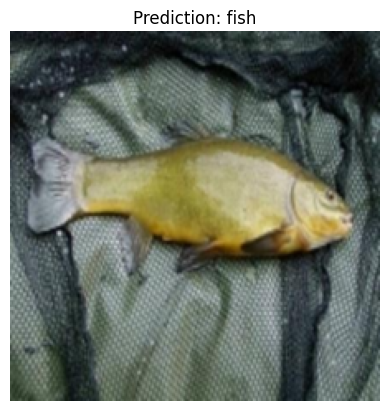

In [19]:
plt.imshow(np.transpose(clean_x[3], (1, 2, 0)))
plt.title(f'Prediction: {label_names[clean_preds[3]]}')
plt.axis('off')
plt.show()

### Re-evaluate on Poisoned Data

In [20]:
poison_x = x_poison[is_poison]
poison_y = y_poison[is_poison]

outputs = trainer.classifier.predict(poison_x)
poison_preds = np.argmax(outputs, axis=1)
poison_acc = np.mean(poison_preds == poison_y)
print('poison success rate:', poison_acc)

poison success rate: 0.16


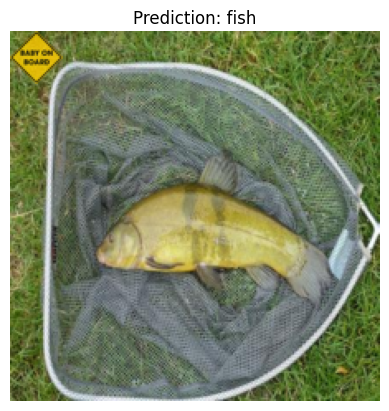

In [21]:
plt.imshow(np.transpose(poison_x[4], (1, 2, 0)))
plt.title(f'Prediction: {label_names[poison_preds[4]]}')
plt.axis('off')
plt.show()